# 自動特徴量選択による次元削減とSVMを用いたMNISTの分類

## はじめに
    MNISTという数字手書き文字のデータセットがある。このデータは28×28ピクセルの手書き数字の画像に対して、0から9までのラベルが振られたデータである。このレポートでは、10000枚の手書き数字の画像がそれぞれ0から9までのどの数字にあたるかを識別するモデルの生成、および生成モデルを用いた推論を実装する。また、性能向上のために用いた交差検証、グリッドサーチ、および自動特徴量選択についても記載する。

In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

DATAPATH = "data/digits.csv"
df = pd.read_csv(DATAPATH)
X = df.drop("label",axis=1).values
y = df["label"].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [23]:
pipe = Pipeline([("scalar", StandardScaler()),("svm",svm.SVC(C= 1000, degree= 2, 
                                                           gamma = 0.001, kernel = 'poly'))])
pipe_grid = Pipeline([("scalar", StandardScaler()),("svm",svm.SVC())])    
selecter_pipe = Pipeline([("scalar", StandardScaler()),
                         ("select",SelectFromModel(RFC(n_estimators=100,random_state=42),
                                                   threshold="median"))])

0       1
1       0
2       1
3       4
4       0
5       0
6       7
7       3
8       5
9       3
10      8
11      9
12      1
13      3
14      3
15      1
16      2
17      0
18      7
19      5
20      8
21      6
22      2
23      0
24      2
25      3
26      6
27      9
28      9
29      7
       ..
9970    4
9971    2
9972    8
9973    6
9974    0
9975    8
9976    2
9977    1
9978    0
9979    4
9980    2
9981    1
9982    3
9983    1
9984    7
9985    7
9986    6
9987    5
9988    6
9989    2
9990    7
9991    3
9992    4
9993    6
9994    1
9995    5
9996    0
9997    4
9998    7
9999    9
Name: label, Length: 10000, dtype: int64


In [ ]:
def fit_model_CV(X_train,X_test,y_train,y_test,pipe):
        parameters = [
                    {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['linear']},
                    {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['rbf'], 'svm__gamma': [0.001, 0.0001]},
                    {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4], 'svm__gamma': [0.001, 0.0001]},
                    {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['sigmoid'], 'svm__gamma': [0.001, 0.0001]}]
        clf = GridSearchCV(pipe, param_grid=parameters,verbose=2,n_jobs=-1,cv=2)
        clf.fit(X_train,y_train)
        print("Best cv accuracy:{:.2f}".format(clf.best_score_))
        print("Test set score: {:.2f}".format(clf.score(X_test,y_test)))
        print("Best parameters:{}".format(clf.best_params_))
        return pipe

In [ ]:
fit_model_CV(X_train,X_test,y_train,y_test,pipe_grid)

In [7]:
X_train_l1 = selecter_pipe.fit_transform(X_train,y_train)
X_test_l1 = selecter_pipe.transform(X_test)

C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
y_pred = clf.predict(X_test_l1)
print(clf.score(X_test_l1,y_test))
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

0.969
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       216
          1       0.99      0.98      0.99       195
          2       0.96      0.95      0.96       198
          3       0.97      0.96      0.97       202
          4       0.97      0.97      0.97       200
          5       0.96      0.97      0.97       182
          6       1.00      0.97      0.98       218
          7       0.98      0.95      0.96       209
          8       0.94      0.95      0.94       196
          9       0.94      0.98      0.96       184

avg / total       0.97      0.97      0.97      2000

[[214   0   0   0   0   0   1   0   0   1]
 [  0 192   0   1   0   1   0   1   0   0]
 [  1   0 189   0   2   0   0   1   5   0]
 [  0   0   1 194   0   1   0   0   6   0]
 [  0   0   2   0 195   0   0   0   0   3]
 [  0   0   2   2   0 177   0   0   0   1]
 [  3   0   0   0   0   1 212   0   2   0]
 [  1   1   1   1   2   0   0 198   0   5]
 [  1   0  

In [13]:
wrong_prediction = []
for counter,i in enumerate(y_test):
    if y_test[counter] == 8:
        if y_pred[counter]!=i:
            keep_list = [counter,y_pred[counter]]
            wrong_prediction.append(keep_list)
print(wrong_prediction)

[[103, 5], [111, 5], [502, 5], [758, 3], [803, 9], [1305, 5], [1374, 0], [1552, 9], [1839, 3]]


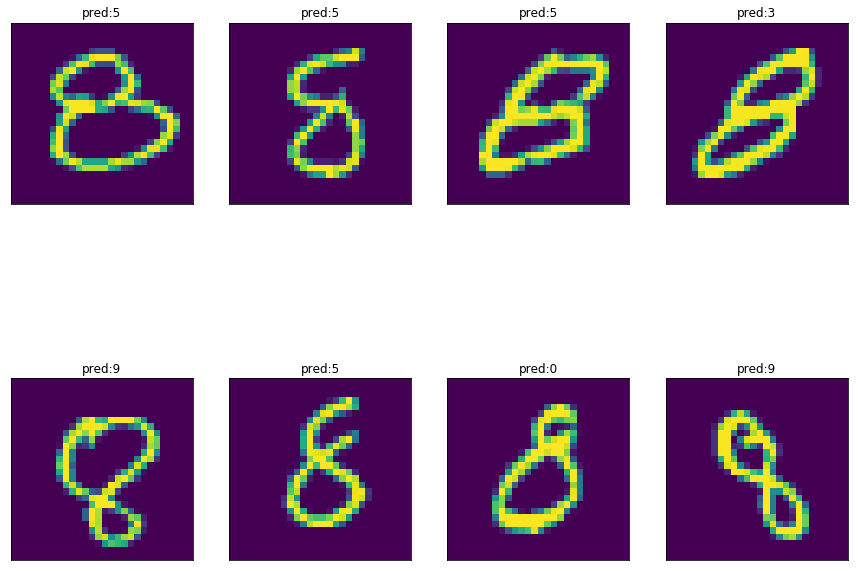

In [15]:
image_shape = [28,28]
fix, axes = plt.subplots(2,4,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction,axes.ravel()):
    ax.imshow(X_test[i[0]].reshape(image_shape))
    ax.set_title("pred:{}".format(i[1]))

In [19]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.9575
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       216
          1       0.96      0.98      0.97       195
          2       0.96      0.96      0.96       198
          3       0.96      0.94      0.95       202
          4       0.95      0.95      0.95       200
          5       0.94      0.98      0.96       182
          6       1.00      0.96      0.98       218
          7       0.97      0.92      0.94       209
          8       0.92      0.94      0.93       196
          9       0.94      0.95      0.95       184

avg / total       0.96      0.96      0.96      2000

[[214   0   0   0   0   1   0   0   0   1]
 [  0 192   1   1   0   0   0   1   0   0]
 [  0   0 190   2   2   0   0   1   3   0]
 [  0   2   0 189   0   2   0   0   8   1]
 [  1   1   0   0 191   2   0   0   1   4]
 [  0   2   1   1   0 178   0   0   0   0]
 [  1   1   1   0   0   2 210   0   3   0]
 [  1   2   4   0   4   1   0 192   1   4]
 [  2   1 

In [21]:
wrong_prediction_8_l1 = []
for counter,i in enumerate(y_test):
    if y_test[counter] == 8:
        if y_pred[counter]!=i:
            keep_list = [counter,y_pred[counter]]
            wrong_prediction_8_l1.append(keep_list)
print(wrong_prediction_8_l1)

[[103, 5], [337, 5], [758, 0], [1264, 4], [1374, 0], [1444, 3], [1478, 3], [1513, 4], [1552, 9], [1565, 5], [1716, 1], [1839, 5]]


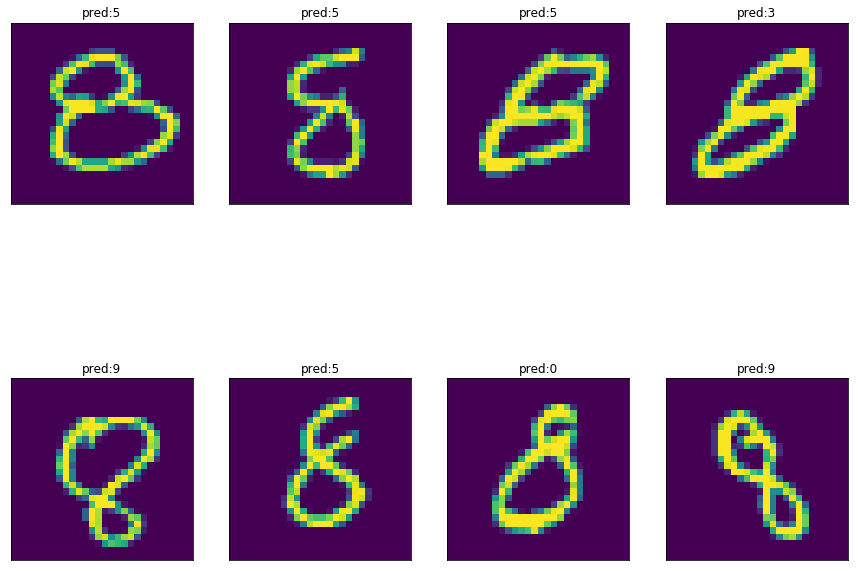

In [22]:
fix, axes = plt.subplots(2,4,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction,axes.ravel()):
    ax.imshow(X_test[i[0]].reshape(image_shape))
    ax.set_title("pred:{}".format(i[1]))